In [3]:
import torch
from datasets import load_dataset
from torchvision import transforms
from torch.utils.data import DataLoader

from model import UNet, DiffusionModel
from model.diffusion_ import DenoiseDiffusion

In [4]:
from PIL import Image
from torchvision.transforms.functional import to_pil_image

def make_grid(images, rows, cols):
    c, w, h = images[0].size()
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, image in enumerate(images):
        grid.paste(to_pil_image(image), box=(i%cols*w, i//cols*h))
    return grid

In [5]:
dataset = load_dataset("huggan/smithsonian_butterflies_subset")

Using custom data configuration huggan--smithsonian_butterflies_subset-dca27cc6049931aa
Found cached dataset parquet (/home1/irteam/.cache/huggingface/datasets/huggan___parquet/huggan--smithsonian_butterflies_subset-dca27cc6049931aa/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
def transform(examples):
    jitter = transforms.Compose([
        transforms.Resize((64,64)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.50], std=[0.5]),
     ])
    image_tensors = [jitter(image.convert("RGB")) for image in examples["image"]]
    return {'img_input': image_tensors}

In [7]:
train_dataset = dataset['train']
train_dataset.set_transform(transform)
train_dataloader = DataLoader(train_dataset, batch_size=16)

In [8]:
sample_image = train_dataset[0]['img_input']

In [9]:
noise = torch.randn(sample_image.shape)

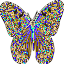

In [10]:
to_pil_image(sample_image)

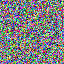

In [11]:
to_pil_image(noise)

In [25]:
model = UNet(in_dim=64,
             dim_mults = (1, 2, 2, 4),
             is_attn = (False, False, True, False)
             )
ddpm_ = DiffusionModel(model = model,
                      num_timesteps=1000)
ddpm = DenoiseDiffusion(
    eps_model = model,
    n_steps=1000,
    device=torch.device("cuda:3"))


In [13]:
ddpm.sample()

AttributeError: 'DenoiseDiffusion' object has no attribute 'sample'

In [23]:
ddpm.eps_model.to(torch.device("cuda:3"))

UNet(
  (init_conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_emb): TimeEmbedding(
    (ln1): Linear(in_features=64, out_features=256, bias=True)
    (act1): GELU()
    (ln2): Linear(in_features=256, out_features=256, bias=True)
  )
  (downs): ModuleList(
    (0): DownBlock(
      (convres): ConvResBlock(
        (norm1): GroupNorm(8, 64, eps=1e-05, affine=True)
        (act1): GELU()
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm2): GroupNorm(8, 128, eps=1e-05, affine=True)
        (act2): GELU()
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (res): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
        (time_ln): Linear(in_features=256, out_features=128, bias=True)
        (time_act): GELU()
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (attn): Identity()
    )
    (1): DownBlock(
      (convres): ConvResBlock(
        (norm1): GroupNor

In [24]:
ddpm.loss(next(enumerate(train_dataloader))[1]['img_input'].to(torch.device("cuda:3")))

tensor(1.1451, device='cuda:3', grad_fn=<MseLossBackward>)

In [29]:
ddpm_.to(torch.device("cuda:3"))
ddpm_(next(enumerate(train_dataloader))[1]['img_input'].to(torch.device("cuda:3")))

tensor(1.1160, device='cuda:3', grad_fn=<MeanBackward0>)